In [3]:
import os
# Ignore Tensorflow Warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

from keras.models import load_model

%matplotlib widget

In [ ]:
8808+150*48

The sample_num variable defines which of the data samples should be predicted and plotted along with the input of the neural network and high-resolution reference. The script computes this automatically for significant wave height, wave period, and direction and plots in in the same fashion as presented in the article. Allowed values for sample_num range from 8808 to 17448 in steps of 48, spanning the whole year of test data. We uploaded only bi-daily data, since the whole hourly data set would be too large. However, it still allows to visualize the strong and weak points of the model. 

Some example sample numbers:

11400: Example from the article

16008: Low wave height --> corresponding detoriation of the results

17285: Very large wave height --> patterns are still somewhat recognizable, even though worse than usual

In [20]:
sample_num = 11400

In [21]:
# Model information (used later for image output)
model_dates = ["20220307", "20220307", "20220308"]
kernel = 16

# Additional run info

variables = ["Hs", "Tm02", "Dir"]
inp_grid = (10, 10)
out_grid = (inp_grid[0]*kernel, inp_grid[1]*kernel)
convert = True # Is Direction data to be shifted? 
nan_thresholds = [0.1, 3, 280] # Threshold under which values are set to NaN, for dir it's high due to the shifting

# Save the figure?
save = False

# Load best models into list
best_models = []
for i in range(len(model_dates)):
    fmodel = "Models/Weights_{}_{}.hdf5"
    fmodel = fmodel.format(variables[i], model_dates[i]) 
    best_models.append(load_model(fmodel))


im_LRs = []
im_HRs = []

# Load the LR and HR images 
for var in variables:
    # Load LR - Data and reference
    fn_LR = "Data/LR/{}/BaskCoast_{}_{}.csv".format(var, var.upper(), sample_num)
    im_LRs.append(pd.read_csv(fn_LR, header=None))
    
    fn_HR = "Data/HR/{}/BaskCoast_{}_{}.csv".format(var, var.upper(), sample_num)
    im_HRs.append(pd.read_csv(fn_HR, header=None))

In [22]:
LR_Ts = []
for i, var in enumerate(variables):
    LR_Ts.append(im_LRs[i]) 
    if var == "Dir" and convert:
        LR_Ts[i] = tf.convert_to_tensor(np.nan_to_num((im_LRs[i].values + 105)%360))
    else:
        LR_Ts[i] = tf.convert_to_tensor(np.nan_to_num(im_LRs[i].values))
    
    LR_Ts[i] = tf.reshape(LR_Ts[i], [1, inp_grid[0], inp_grid[1], 1])

preds = []
for i in range(len(LR_Ts)):
    if variables[i] == "Dir" and convert:
        pred = (best_models[i].predict(LR_Ts[i])[0,:,:,0] + 255)%360
    else:
        pred = best_models[i].predict(LR_Ts[i])[0,:,:,0]
    
    pred[pred<nan_thresholds[i]] = np.nan
    preds.append(pred)


# Plot of all reconstructions

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
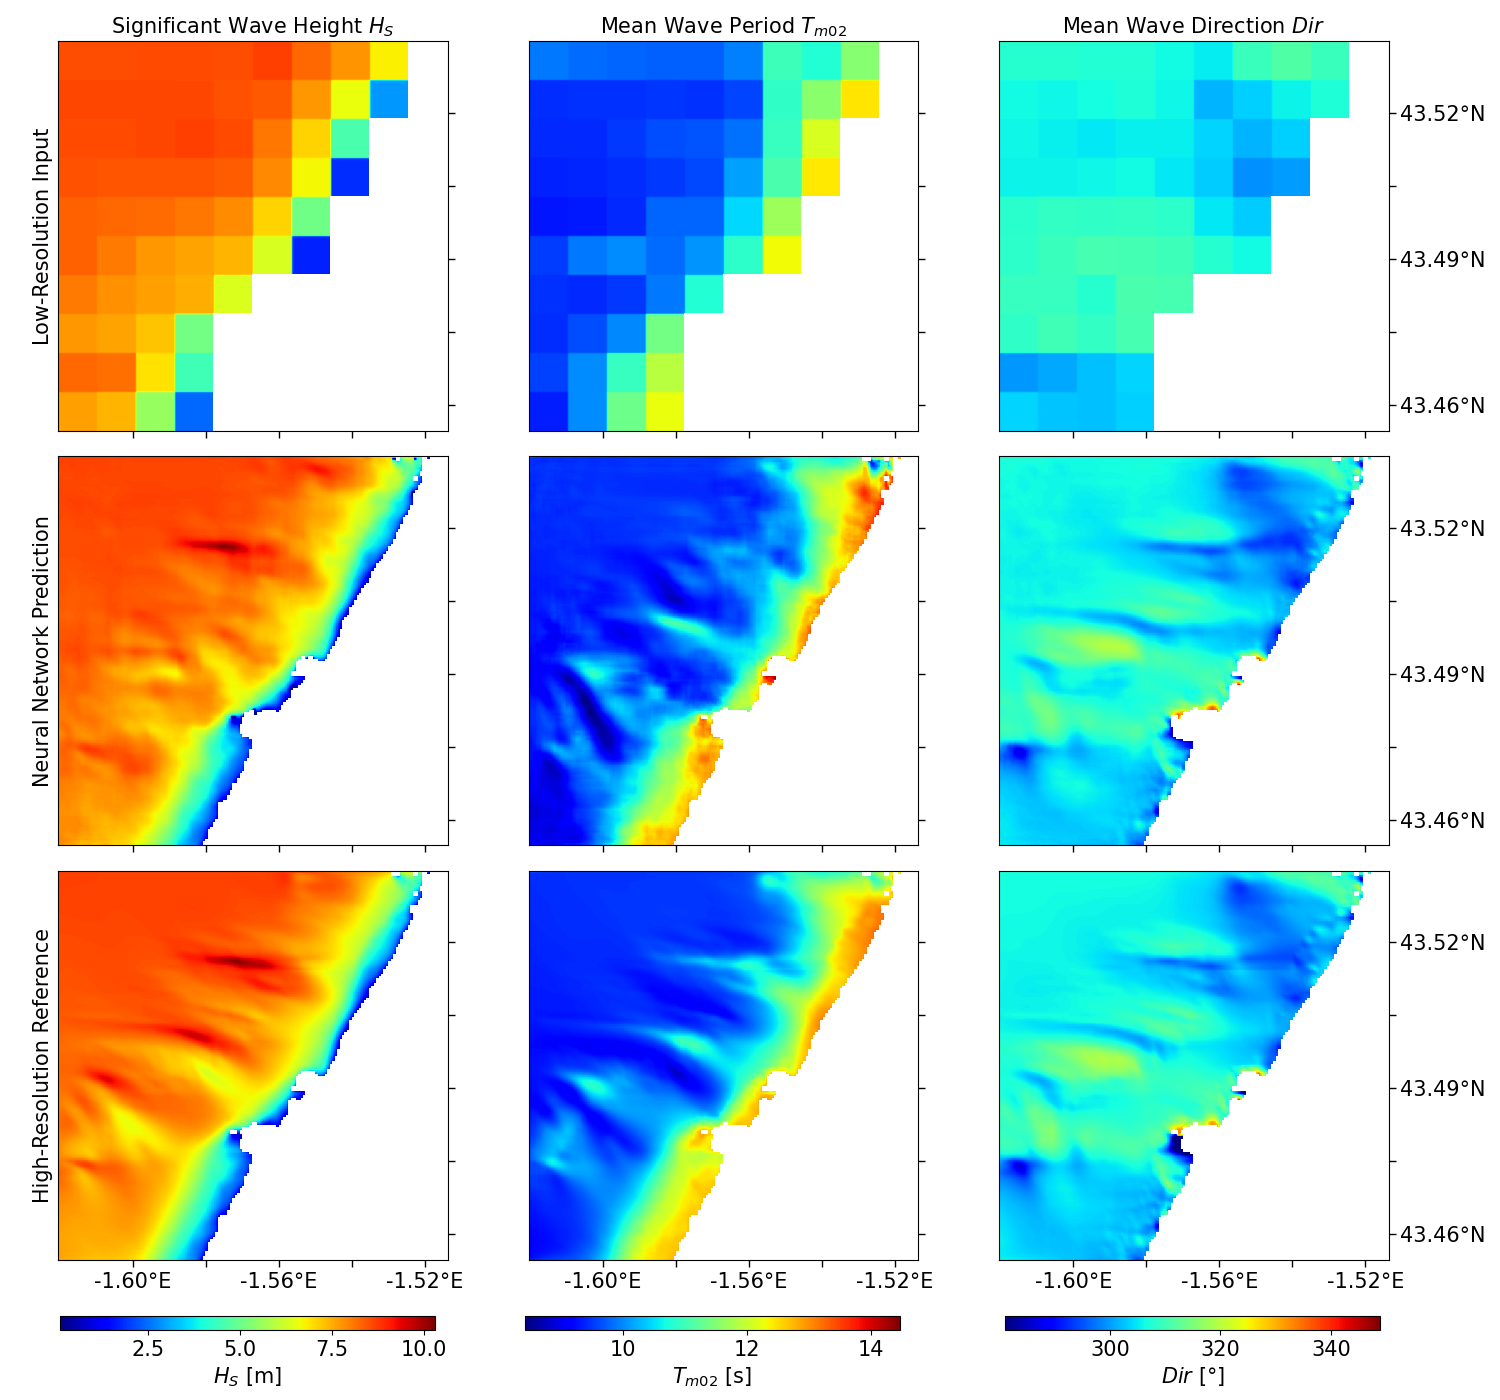

In [23]:
# Format axes in a nice way
x = ["-1.60°E", "", "-1.56°E", "", "-1.52°E"]
y = ["43.46°N", "", "43.49°N", "", "43.52°N"]

# Get the position of the ticks
x_loc = np.arange(30, 160, 30)
y_loc = np.arange(10, 160, 30)

# Output folder and file name
fname = "Plots/MainPlot_sample_{}.png".format(sample_num)

# Compute RMSE 
mses = []
for i in range(len(preds)):
    mses.append(((np.nan_to_num(preds[i]) - im_HRs[i].fillna(0).values)**2).mean())

# Set vmax (TODO)
#vmax=2.15
vmin0 = np.nanmin(preds[0])
vmax0 = np.nanmax(preds[0])

vmin1 = np.nanmin(preds[1])
vmax1 = np.nanmax(preds[1])

vmin2 = np.nanmin(preds[2])
vmax2 = np.nanmax(preds[2])

# Some plotting constants for the ticks
LABELSIZE = 15
LENGTH = 5.0
WIDTH= 1.0

# Colorbar Properties
CB_BOTTOM = 0.05
CB_WIDTH = 0.25
CB_HEIGHT = 0.01
CB_LEFT0 = 0.04
CB_LEFT1 = 0.35
CB_LEFT2 = 0.67


fig, axs = plt.subplots(3, 3, figsize=(15,14))
plt.rc('axes', labelsize=15) 
plt.rc('axes', titlesize=15)

############################# First Row
# Note the upsampling for plotting

LR = im_LRs[0].values.repeat(kernel, axis=0).repeat(kernel, axis=1)
axs[0,0].imshow(LR, cmap="jet", origin="lower", vmin=vmin0, vmax=vmax0)
axs[0,0].set_ylabel("Low-Resolution Input")
axs[0,0].set_title(r"Significant Wave Height $H_S$")
axs[0,0].set_xticks(x_loc)
axs[0,0].set_yticks(y_loc)
axs[0,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[0,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

LR = im_LRs[1].values.repeat(kernel, axis=0).repeat(kernel, axis=1)
axs[0,1].imshow(LR, cmap="jet", origin="lower", vmin=vmin1, vmax=vmax1)
axs[0,1].set_title(r"Mean Wave Period $T_{m02}$")
axs[0,1].set_xticks(x_loc)
axs[0,1].set_yticks(y_loc)
axs[0,1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[1,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

LR = im_LRs[2].values.repeat(kernel, axis=0).repeat(kernel, axis=1)
axs[0,2].imshow(LR, cmap="jet", origin="lower", vmin=vmin2, vmax=vmax2)
axs[0,2].set_title(r"Mean Wave Direction $Dir$")
axs[0,2].set_xticks(x_loc)
axs[0,2].set_yticks(y_loc, y)
axs[0,2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
axs[0,2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)



############################ Second Row

pos0 = axs[1,0].imshow(preds[0], cmap="jet", origin="lower", vmin=vmin0, vmax=vmax0)
#axs[1,0].set_title("MSE: {:.1e}".format(mses[0]))
axs[1,0].set_ylabel("Neural Network Prediction")
axs[1,0].set_xticks(x_loc)
axs[1,0].set_yticks(y_loc)
axs[1,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[0,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


pos1 = axs[1,1].imshow(preds[1], cmap="jet", origin="lower", vmin=vmin1, vmax=vmax1)
#axs[1,1].set_title("MSE: {:.1e}".format(mses[1]))
axs[1,1].set_xticks(x_loc)
axs[1,1].set_yticks(y_loc)
axs[1,1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
axs[1,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


pos2 = axs[1,2].imshow(preds[2], cmap="jet", origin="lower", vmin=vmin2, vmax=vmax2)
#axs[1,2].set_title("MSE: {:.1e}".format(mses[2]))
axs[1,2].set_xticks(x_loc)
axs[1,2].set_yticks(y_loc, y)
axs[1,2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=False)
axs[1,2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


############################ Third Row

plt.tight_layout()

axs[2,0].imshow(im_HRs[0].values, cmap="jet", origin="lower", vmin=vmin0, vmax=vmax0)
axs[2,0].set_xticks(x_loc, x)
axs[2,0].set_yticks(y_loc)
axs[2,0].set_ylabel("High-Resolution Reference")
axs[2,0].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[2,0].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

fig.subplots_adjust(bottom=0.1)
cbar_ax0 = fig.add_axes([CB_LEFT0, CB_BOTTOM, CB_WIDTH, CB_HEIGHT])
fig.colorbar(pos0, ax=axs[:,0], cax=cbar_ax0, orientation="horizontal", label=r"$H_S$ [m]")
cbar_ax0.tick_params(labelsize=LABELSIZE) 


axs[2,1].imshow(im_HRs[1].values, cmap="jet", origin="lower", vmin=vmin1, vmax=vmax1)
axs[2,1].set_xticks(x_loc, x)
axs[2,1].set_yticks(y_loc)
axs[2,1].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=False, labelbottom=True)
axs[2,1].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)

fig.subplots_adjust(bottom=0.1)
cbar_ax1 = fig.add_axes([CB_LEFT1, CB_BOTTOM, CB_WIDTH, CB_HEIGHT])
fig.colorbar(pos1, ax=axs[:,1], cax=cbar_ax1, orientation="horizontal", label=r"$T_{m02}$ [s]")
cbar_ax1.tick_params(labelsize=LABELSIZE) 


axs[2,2].imshow(im_HRs[2].values, cmap="jet", origin="lower", vmin=vmin2, vmax=vmax2)
axs[2,2].set_xticks(x_loc, x)
axs[2,2].set_yticks(y_loc, y)
axs[2,2].tick_params(axis='both', left=False, top=False, right=True, bottom=True,
                     labelleft=False, labeltop=False, labelright=True, labelbottom=True)
axs[2,2].tick_params(labelsize=LABELSIZE, length=LENGTH, width=WIDTH)


fig.subplots_adjust(bottom=0.1)
cbar_ax2 = fig.add_axes([CB_LEFT2, CB_BOTTOM, CB_WIDTH, CB_HEIGHT])
fig.colorbar(pos2, ax=axs[:,2], cax=cbar_ax2, orientation="horizontal", label=r"$Dir$ [°]")
cbar_ax2.tick_params(labelsize=LABELSIZE) 

#plt.suptitle(title)


if save:
    if not os.path.isdir(fdir):
        os.makedirs(fdir)
    plt.savefig(os.path.join(fdir, fname))
                         
plt.show()